In [18]:
import re

In [19]:
non_word_char_in_word = re.compile(r"(?<=\w)\W(?=\w)")
not_for_output = {'<PAD>', '<SOS>', '<EOS>', '<UNK>'}

In [20]:
def format_tokens(tokens: list, newline: str= '<P>', for_rouge: bool=False) -> str:
  """Join output `tokens` for ROUGE evaluation."""
  tokens = filter(lambda t: t not in not_for_output, tokens)
  if for_rouge:
    tokens = [non_word_char_in_word.sub("", t) for t in tokens]  # "n't" => "nt"
  if newline is None:
    s = ' '.join(tokens)
  else:  # replace newline tokens by newlines
    lines, line = [], []
    for tok in tokens:
      if tok == newline:
        if line: lines.append(" ".join(line))
        line = []
      else:
        line.append(tok)
    if line: lines.append(" ".join(line))
    s = '\n'.join(lines)
  return s

In [42]:
def rouge(target, predictions):
    result = []
    for i, tgt_tokens in enumerate(target):
        gold_tokens = format_tokens(tgt_tokens, for_rouge=True).split(" ")
        pred_tokens = format_tokens(predictions[i], for_rouge=True).split(" ")
        p = 0
        r = 0
        for gold in gold_tokens:
            if gold in pred_tokens:
                r += 1
        r /= len(gold_tokens)
        
        for pred in pred_tokens:
            if pred in gold_tokens:
                p += 1
                print(pred, p)
        p /= len(pred_tokens)

        f = (2*p*r)/(p+r+1e-8)
        result.append({'1_f':f,'1_r':r,'1_p':p})
    return result

In [43]:
rouge([one_gram("rotate the tick labels and"," ")], [one_gram("rotate the tick labels"," ")])

['and', 'tick', 'the', 'labels', 'rotate']
['the', 'labels', 'rotate', 'tick']
tick 1
the 2
labels 3
rotate 4
the 1
labels 2
rotate 3
tick 4


[{'l_f': 0.8888888839506174, 'l_r': 0.8, 'l_p': 1.0}]

In [2]:
def cal_rouge(evaluated_ngrams, reference_ngrams):
    reference_count = len(reference_ngrams)
    evaluated_count = len(evaluated_ngrams)

    overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
    overlapping_count = len(overlapping_ngrams)

    if evaluated_count == 0:
        precision = 0.0
    else:
        precision = overlapping_count / evaluated_count

    if reference_count == 0:
        recall = 0.0
    else:
        recall = overlapping_count / reference_count

    f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))
    return {"f": f1_score, "p": precision, "r": recall}

In [3]:
def one_gram(sent, sep="<tokesep>"):
    return set(sent.split(sep)) 
def two_gram(sent, sep="<tokesep>"):
    last = ""
    grams = []
    first = True
    for word in sent.split(sep):
        if first:
            first = False
        else:
            grams.append("{} {}".format(last, word))
        last = word
    return set(grams)

In [9]:
cal_rouge(one_gram("rotate the tick labels and"," "), one_gram("rotate the tick labels"," "))

{'f': 0.8888888839506174, 'p': 0.8, 'r': 1.0}

In [5]:
path = "tokened/test"
sub_path = path+"_token_sub.txt"
doc_path = path+"_token_doc.txt"    
reader_sub = open(sub_path)
reader_doc = open(doc_path)

rouge_max = {"1_gram":[], "2_gram":[]}
while True:
    doc_token = reader_doc.readline().replace("\n","")
    sub_token = reader_sub.readline().replace("\n","")
    if not doc_token:
        reader_doc.close()
        reader_sub.close()
        break
    
    target = sub_token.replace("<sentsep>", "<tokesep>")
    gram_max_f_1 = 0
    gram_max_cache_1 = {'f':0, 'p':0, 'r':0}
    gram_max_f_2 = 0
    gram_max_cache_2 = {'f':0, 'p':0, 'r':0}
    for index, sent in enumerate(doc_token.split("<sentsep>")):
        gram_1 = cal_rouge(one_gram(sent), one_gram(target))
        if gram_1['f'] > gram_max_f_1:
            gram_max_cache_1 = gram_1
            gram_max_f_1 = gram_1['f']
        gram_2 = cal_rouge(two_gram(sent), two_gram(target))
        if gram_2['f'] > gram_max_f_2:
            gram_max_cache_2 = gram_2 
            gram_max_f_2 = gram_2['f']
    rouge_max["1_gram"].append([gram_max_cache_1['f'],
                               gram_max_cache_1['p'],
                               gram_max_cache_1['r']])
    rouge_max["2_gram"].append([gram_max_cache_2['f'],
                               gram_max_cache_2['p'],
                               gram_max_cache_2['r']])
#     rouge_max["1_gram"].append(gram_max_f_1)
#     rouge_max["2_gram"].append(gram_max_f_2)

reader_doc.close()
reader_sub.close()

In [13]:
res = np.array(rouge_max['1_gram'])

In [17]:
np.sum(res, axis = 0)/res.shape[0]

array([0.15000229, 0.11877597, 0.34643681])

(1906, 3)

In [9]:
import numpy as np

In [67]:
gram_1 = np.array(rouge_max['1_gram'])
gram_2 = np.array(rouge_max['2_gram'])

In [68]:
import matplotlib.pyplot as plt
def plot_hist(data, bins, title, xlabel, ylabel):
    plt.hist(data, bins=bins, histtype="bar", rwidth=0.9, alpha=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
def plot_box(data, title="", xlabel="", ylabel=""):
    print("Range:", "({}, {})".format(min(data), max(data)))
    print("  Avg:", sum(data)/len(data))
    plt.boxplot(data, vert=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
def plot_stat(data, bins=None, describe=""):
    plot_box(data, "Box: "+describe, "count", describe)
    plot_hist(data, bins, "Hist: "+describe, describe, "dount")

Range: (0.0, 0.999999995)
  Avg: 0.15000229035763518


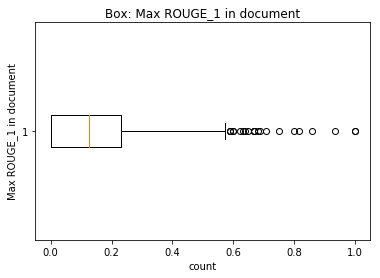

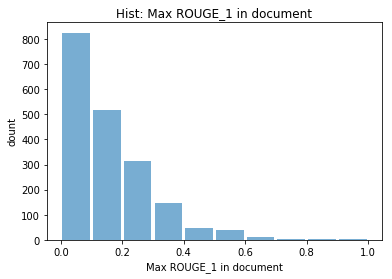

In [69]:
plot_stat(gram_1, None, "Max ROUGE_1 in document")

Range: (0.0, 0.999999995)
  Avg: 0.053776097529671975


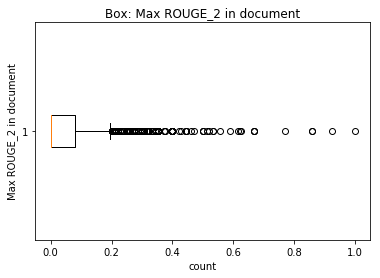

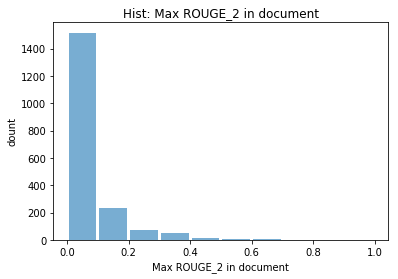

In [70]:
plot_stat(gram_2, None, "Max ROUGE_2 in document")

In [71]:
sum(gram_1>0.25)/len(gram_1)

0.19989506820566633